# XY - Regression - Group 11

In [1]:
import os
import cv2
import subprocess
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class LaneDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
        # Transformations
        self.transform = transform if transform else transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            # Normalize using ImageNet stats (standard for ResNet)
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0] # Filename
        img_path = os.path.join(self.root_dir, img_id)
        
        # Check if file exists in folder
        # if image does not ecist take next image
        if not os.path.exists(img_path):
            return self.__getitem__((index + 1) % len(self.annotations))
        
        image = Image.open(img_path).convert("RGB")
        
        # Get the X, Y coordinates
        label = torch.tensor(
            self.annotations.iloc[index, 1:7].values.astype('float32')
        ) # Columns 1 to 6 are labels (coordinates for the three points

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Hyperparameters
batch_size = 16

#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\all"
#csv_file = "labels.csv"

data_dir = "./dataset/all_small_dataset"
csv_file = "./dataset/labels_center_and_lanes.csv"

# Ratio: 80% train, 10% test, 10% validation
train_dir = "./dataset/train_small_dataset" # Training Dataset
test_dir = "./dataset/test_small_dataset"   # Testing Dataset
val_dir = "./dataset/val_small_dataset"     # Validation Dataset

In [5]:
full_dataset = LaneDataset(csv_file=csv_file, root_dir=data_dir)

train_dataset = LaneDataset(csv_file = csv_file, root_dir = train_dir)
test_dataset = LaneDataset(csv_file = csv_file, root_dir = test_dir)
val_dataset = LaneDataset(csv_file = csv_file, root_dir = val_dir)

In [6]:
# Split into Train (80%) and Validation (20%)
#train_size = int(0.8 * len(full_dataset))
#test_size = len(full_dataset) - train_size
#train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)  # check if shuffle needs to be done here too

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # drop last avoids error
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [7]:
class EleveNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(EleveNet, self).__init__()
        
        # Input dimensions: (batch_size, 3, 224, 224)
        
        # Convolutional layers with batch norm
        self.conv1 = nn.Conv2d(3, 28, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(28)
        self.conv2 = nn.Conv2d(28, 56, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(56)
        self.conv3 = nn.Conv2d(56, 112, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(112)
        self.conv4 = nn.Conv2d(112, 224, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(224)

        self.pooling = nn.MaxPool2d(2, 2)  # Standard pooling
        
        # for flexible input image resolutions use adaptive pooling:
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(224 * 14 * 14, 128)  # 224 * 14 * 14 # prev 192
        #self.linear1 = nn.Linear(112 * 28 * 28, 128)  # 224 * 14 * 14 # prev 192
        self.bn5 = nn.BatchNorm1d(128) # prev 192

        self.dropout = nn.Dropout(p=dropout_prob)
        self.output = nn.Linear(128, 6) # prev 15

    def forward(self, x):
        # Input x dimensions: (batch_size, 3, 224, 224)
        
        # Conv block 1
        x = self.conv1(x)  # (batch_size, 28, 224, 224)
        x = self.bn1(x)
        x = self.pooling(x)  # (batch_size, 28, 112, 112)
        #x = self.silu(x)     # x = self.relu()
        #x = self.relu(x)
        x = self.leaky_relu(x)
        
        # Conv block 2
        x = self.conv2(x)  # (batch_size, 56, 112, 112)
        x = self.bn2(x)
        x = self.pooling(x)  # (batch_size, 56, 56, 56)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)
        
        # Conv block 3
        x = self.conv3(x)  # (batch_size, 112, 56, 56)
        x = self.bn3(x)
        x = self.pooling(x)  # (batch_size, 112, 28, 28)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)
        
        # Conv block 4
        x = self.conv4(x)  # (batch_size, 224, 28, 28)
        x = self.bn4(x)
        x = self.pooling(x)  # (batch_size, 224, 14, 14)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)

        # Flatten
        # After 4 pooling layers: (batch_size, 224, 14, 14)
        x = self.flatten(x)  # (batch_size, 224 * 14 * 14) = (batch_size, 43904)

        # Adaptive pooling for flexible image size
        #x = self.adaptive_pool(x)  # (batch_size, 1024, 3, 3)
        
        x = self.linear1(x)  # (batch_size, 192)
        x = self.bn5(x)
        #x = self.silu(x)
        #x = self.relu(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.output(x)  # (batch_size, num_classes)

        return x

In [8]:
model = EleveNet(dropout_prob=0.3).to(device)  # For 30% dropout

In [9]:
summary(model, input_size = (3, 224, 224))    # if using torchsummary # change back to 128 128

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 28, 224, 224]             784
       BatchNorm2d-2         [-1, 28, 224, 224]              56
         MaxPool2d-3         [-1, 28, 112, 112]               0
         LeakyReLU-4         [-1, 28, 112, 112]               0
            Conv2d-5         [-1, 56, 112, 112]          14,168
       BatchNorm2d-6         [-1, 56, 112, 112]             112
         MaxPool2d-7           [-1, 56, 56, 56]               0
         LeakyReLU-8           [-1, 56, 56, 56]               0
            Conv2d-9          [-1, 112, 56, 56]          56,560
      BatchNorm2d-10          [-1, 112, 56, 56]             224
        MaxPool2d-11          [-1, 112, 28, 28]               0
        LeakyReLU-12          [-1, 112, 28, 28]               0
           Conv2d-13          [-1, 224, 28, 28]         226,016
      BatchNorm2d-14          [-1, 224,

In [76]:
# Hyperparameters
lr = 0.001
epochs = 40

# Training Setup
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

print(f"Training on {device} with {len(train_dataset)} images")

Training on cuda with 399 images


In [77]:
train_losses = []
val_losses = []
train_maes = [] # mean absolut error (between prediction and label)
val_maes = []

# calculate metric for regression (accuracy)
def calculate_mae(outputs, labels):
    return torch.abs(outputs - labels).mean().item() # how far is the prediction off to the actual labels (groudn truth)

In [ ]:
best_val_loss = float('inf')

# training loop
for epoch in range(epochs):
    # training
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    
    # loading bar for showing progress
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", unit="batch", leave=False)
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        current_mae = calculate_mae(outputs, labels)
        running_mae += current_mae
        
        # Update the progress bar with the current batch loss
        train_bar.set_postfix(loss=f"{loss.item():.4f}", mae=f"{current_mae:.4f}")
    
    avg_train_loss = running_loss / len(train_loader)
    avg_train_mae = running_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)
    
    # validation
    model.eval()
    running_val_loss = 0.0
    running_val_mae = 0.0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", unit="batch", leave=False)
    
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            v_loss = loss_fn(outputs, labels).item()
            v_mae = calculate_mae(outputs, labels)
            
            running_val_loss += v_loss
            running_val_mae += v_mae
            
            val_bar.set_postfix(val_loss=f"{v_loss:.4f}", val_mae=f"{v_mae:.4f}")
            
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_mae = running_val_mae / len(val_loader)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)
    
    # print losses etc
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")
    
    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), './models/best_steering_model_xy_EleveNet_center_and_lanes.pth')
        print("Saved Best Model (Validation Loss Improved)\n")

print("\n Training Done")

In [12]:
print("Evaluating on Test Set")

model.load_state_dict(torch.load('./models/best_steering_model_xy_EleveNet_center_and_lanes.pth')) # Load best version
model.eval()

final_test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        final_test_loss += loss.item()

avg_test_loss = final_test_loss / len(test_loader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

Evaluating on Test Set
Final Test Loss: 0.0055


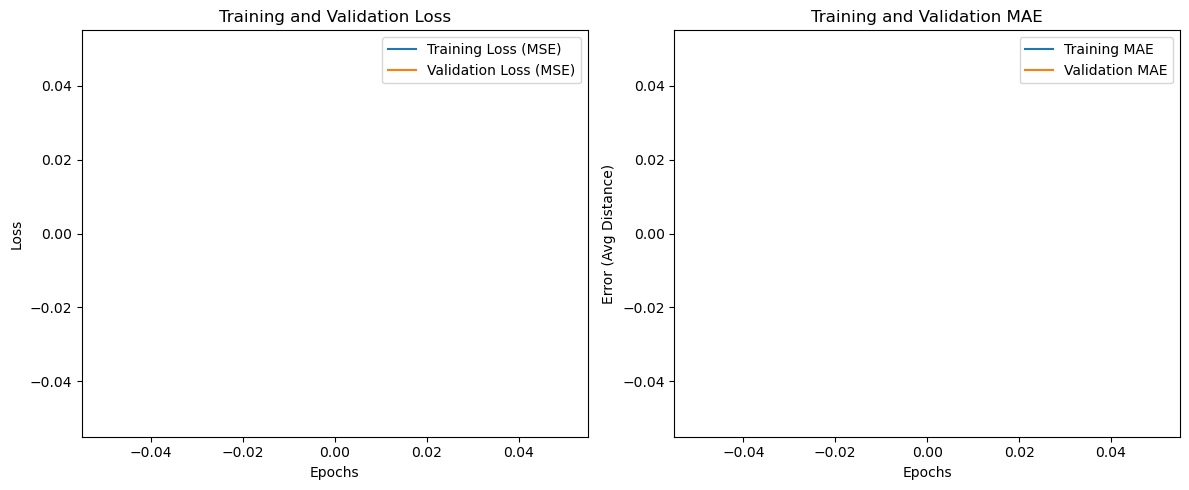

In [13]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss (MSE)')
plt.plot(epochs_range, val_losses, label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Mean Absolute Error (MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_maes, label='Training MAE')
plt.plot(epochs_range, val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Error (Avg Distance)')
plt.legend()

plt.tight_layout()
plt.show()

# Load and test model

In [14]:
#image_path = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\big_corr_1_0013.jpg" # one fixed image

image_path = "./dataset/test_small_dataset/frame_000105.png"

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # ImageNet mean and std
    transforms.ConvertImageDtype(torch.float)
])

In [17]:
model.load_state_dict(torch.load('./models/best_steering_model_xy_EleveNet_center_and_lanes.pth'))
model.eval()
print("Done")

Done


In [18]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    #print(image.shape)
    
    model.eval()  # Disables BatchNorm's training behavior
    
    with torch.no_grad():
        image = image.to(device)  # Fixed: assign back to image
        output = model(image)
    
    return output  # Return just the string label instead of array

In [19]:
output = predict_image(image_path)

In [20]:
pred_coord = output.cpu().numpy()
print(pred_coord)

[[0.03402047 0.61104906 0.41723013 0.66712725 0.7912968  0.67267346]]


In [21]:
coordinates = pred_coord[0]

xpred_left = coordinates[0]
ypred_left = coordinates[1]

xpred_center = coordinates[2]
ypred_center = coordinates[3]

xpred_right = coordinates[4]
ypred_right = coordinates[5]

print(f"left x = {xpred_left}, y = {ypred_left}")
print(f"center x = {xpred_center}, y = {ypred_center}")
print(f"left x = {xpred_right}, y = {ypred_right}")

left x = 0.03402046859264374, y = 0.6110490560531616
center x = 0.41723012924194336, y = 0.667127251625061
left x = 0.7912967801094055, y = 0.6726734638214111


In [22]:
image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

In [23]:
# Predictions
pred_x_left = int(np.clip(xpred_left * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_left = int(np.clip(ypred_left * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_center = int(np.clip(xpred_center * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_center = int(np.clip(ypred_center * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_right = int(np.clip(xpred_right * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_right = int(np.clip(ypred_right * image_cv.shape[0], 0, image_cv.shape[0] - 1))

print(f"left x: {pred_x_left}")
print(f"left y: {pred_y_left}")

print(f"center x: {pred_x_center}")
print(f"center y: {pred_y_center}")

print(f"right x: {pred_x_right}")
print(f"right y: {pred_y_right}")

left x: 7
left y: 136
center x: 93
center y: 149
right x: 177
right y: 150


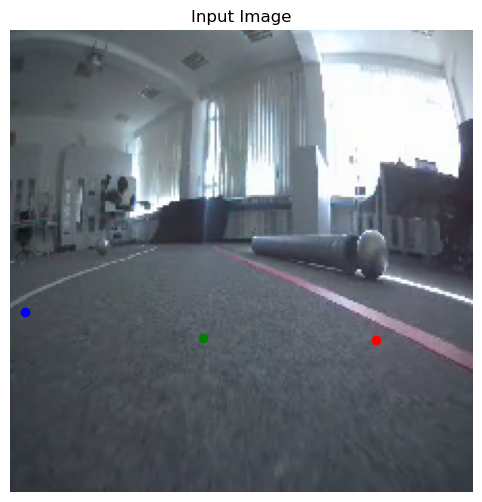

In [24]:
plt.figure(figsize=(12,6))

plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C

#Left (Blue), Center (Green), Right (Red)
plt.plot(pred_x_left, pred_y_left, 'bo')
plt.plot(pred_x_center, pred_y_center, 'go')
plt.plot(pred_x_right, pred_y_right, 'ro')
plt.axis("off")

plt.show()
#plt.savefig("EleveNet_original_14122025")

# Test with random images

In [25]:
#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\val"

data_dir = "./dataset/test_small_dataset"

Random image: frame_007323.png
Done
[[0.13443434 0.68986607 0.4845031  0.684031   0.9620286  0.6943562 ]]
left x: 7
left y: 136
center x: 93
center y: 149
right x: 177
right y: 150


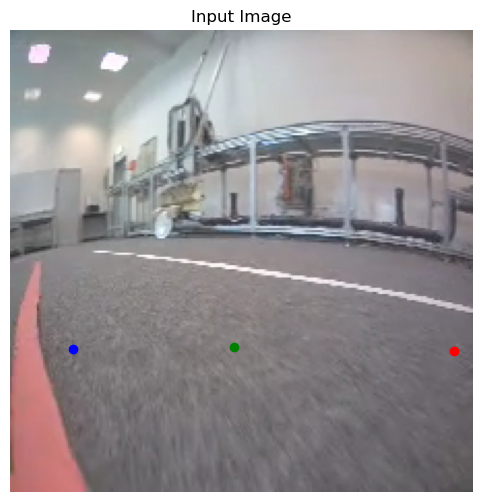

In [26]:
directory = Path(data_dir)
images = [file for file in directory.iterdir()]

random_image = rn.choice(images)
print(f"Random image: {random_image.name}")

image_path = random_image

model.load_state_dict(torch.load('./models/best_steering_model_xy_EleveNet_center_and_lanes.pth'))
model.eval()
print("Done")

output = predict_image(image_path)

pred_coord = output.cpu().numpy()
print(pred_coord)

coordinates = pred_coord[0]

xpred_left = coordinates[0]
ypred_left = coordinates[1]

xpred_center = coordinates[2]
ypred_center = coordinates[3]

xpred_right = coordinates[4]
ypred_right = coordinates[5]

print(f"left x: {pred_x_left}")
print(f"left y: {pred_y_left}")

print(f"center x: {pred_x_center}")
print(f"center y: {pred_y_center}")

print(f"right x: {pred_x_right}")
print(f"right y: {pred_y_right}")

image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

# Denormalize
pred_x_left = int(np.clip(xpred_left * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_left = int(np.clip(ypred_left * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_center = int(np.clip(xpred_center * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_center = int(np.clip(ypred_center * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_right = int(np.clip(xpred_right * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_right = int(np.clip(ypred_right * image_cv.shape[0], 0, image_cv.shape[0] - 1))

# Plot
plt.figure(figsize=(12,6))
plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C

plt.plot(pred_x_left, pred_y_left, 'bo')
plt.plot(pred_x_center, pred_y_center, 'go')
plt.plot(pred_x_right, pred_y_right, 'ro')

plt.axis("off")
plt.show()

## Plot inner layer outputs

In [27]:
# Dict to store layer outputs
activations = {}

# Hook function to store outputs
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()  # Detach to avoid gradients
    return hook

In [28]:
image_path = "./dataset/all_original/frame_000105.png"

In [29]:
image = Image.open(image_path).convert('RGB')
image = transform(image).to(device)
image = image.unsqueeze(0)

In [30]:
# Register hooks for specific layers
hook1 = model.conv1.register_forward_hook(get_activation('conv1'))
hook2 = model.conv2.register_forward_hook(get_activation('conv2'))
hook3 = model.conv3.register_forward_hook(get_activation('conv3'))
hook4 = model.conv4.register_forward_hook(get_activation('conv4'))
#hook5 = model.conv5.register_forward_hook(get_activation('conv5'))
#hook6 = model.conv6.register_forward_hook(get_activation('conv6'))

# Forward pass with a dummy input (or your actual image)
inputs = image   #torch.randn(1, 3, 128, 128)  # (batch, channels, height, width)
output = model(inputs)

# Remove hooks (important to avoid memory leaks)
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
#hook5.remove()
#hook6.remove()

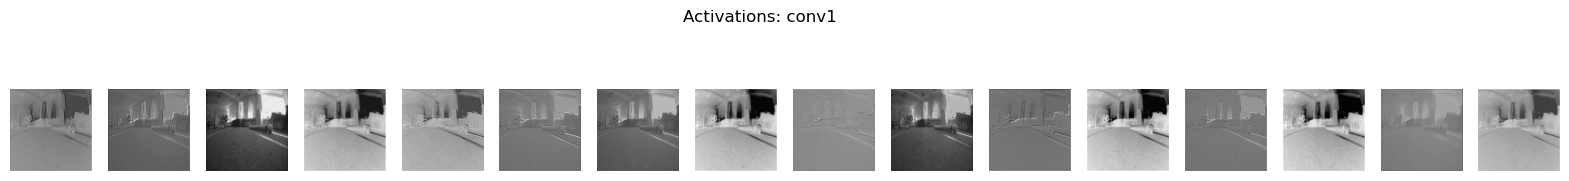

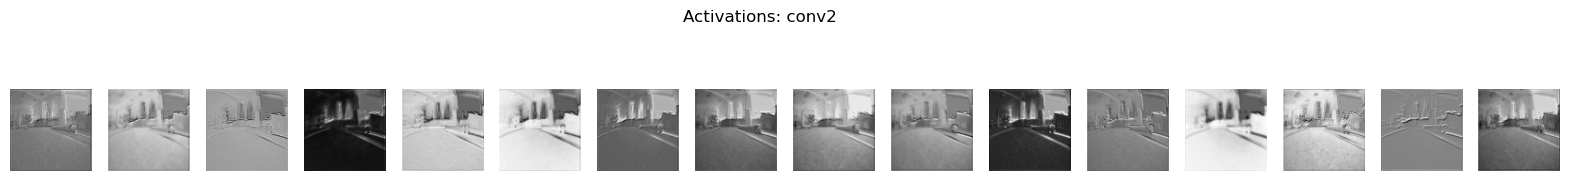

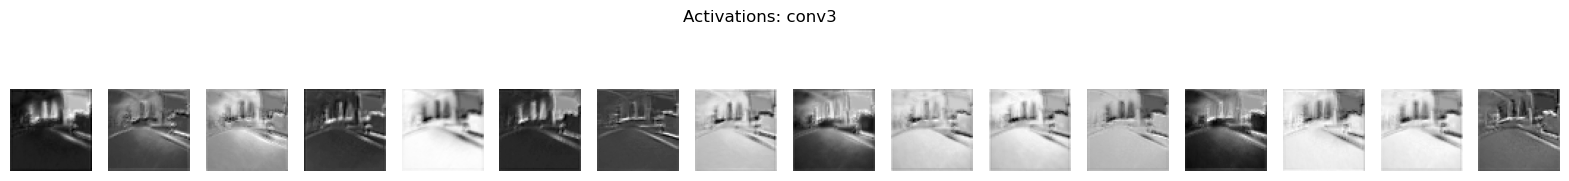

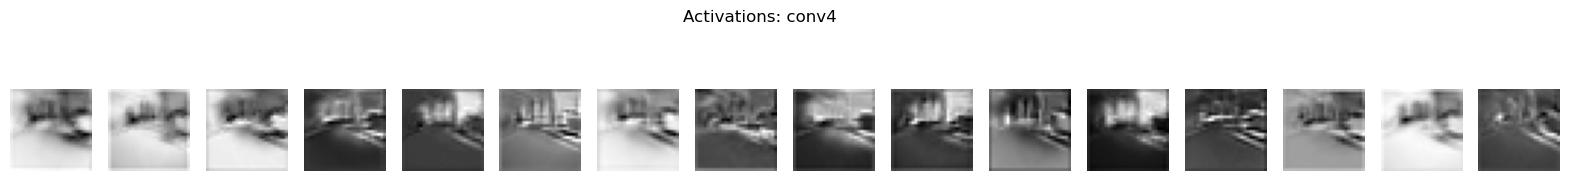

In [31]:
# Visualize feature maps
def visualize_activations(layer_name, num_filters=16):
    act = activations[layer_name].squeeze(0)  # Remove batch dim
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 2))
    for i in range(num_filters):
        axes[i].imshow(act[i].cpu(), cmap='gray')  # Show i-th filter's output
        axes[i].axis('off')
    plt.suptitle(f'Activations: {layer_name}', y=1.1)
    plt.show()

# Visualize first 16 filters of conv1 and conv4
visualize_activations('conv1', num_filters=16)
visualize_activations('conv2', num_filters=16)
visualize_activations('conv3', num_filters=16)
visualize_activations('conv4', num_filters=16)
#visualize_activations('conv5', num_filters=16)
#visualize_activations('conv6', num_filters=16)

# Make multiple predictions and measure average

In [32]:
device = torch.device("cuda")
model.to(device).eval()

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up: 10-20 runs to initialize kernels and memory
print("Warming up")
for _ in range(20):
    _ = model(dummy_input)

# Setup for multiple runs
repetitions = 100
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

print(f"\n Statistics")
print(f"Average Inference Time: {mean_syn:.3f} ms")
print(f"Standard Deviation:     {std_syn:.3f} ms")
print(f"Throughput:             {1000/mean_syn:.2f} FPS")

Warming up
Starting 100 iterations

 Statistics
Average Inference Time: 1.199 ms
Standard Deviation:     0.097 ms
Throughput:             833.72 FPS


# Predict point in Video

In [69]:
# Configuration
model_path = './models/best_steering_model_xy_EleveNet_center_and_lanes.pth'

#video_path = 'big_corr_w_obs_a_video.mp4'
# u_corr.mp4
video_path = './BIP_videos_roboter_cam/corr_w_sun_w_obs_2.mp4'

#os.chdir('..')
output_video_path = './inference_videos/output_video_EleveNet_LeakyReLU_center_and_lanes.mp4' # Where the annotated video will be saved

In [70]:
# Defining Image Preprocessing Transforms
# NOTE: These MUST match the inference transforms from training/testing!
inference_transforms = transforms.Compose([
    # Resize the image to 224x224 (standard input size for ResNet)
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    # Normalize using ImageNet stats (standard for ResNet)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [71]:
#image = Image.open(image_path).convert('RGB')
#image = transform(image).to(device)
#image = image.unsqueeze(0)
    
##print(image.shape)
    
#model.eval()  # Disables BatchNorm's training behavior

#with torch.no_grad():
#            output = model(image).cpu().numpy()#[0]

#print(output)

In [72]:
# Video Processing Loop
def process_video(model, video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    # Get video properties for saving the output
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define output video writer
    fourcc = cv2.VideoWriter_fourcc(*'avc1') 
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    print(f"Processing video with {fps} FPS")

    while cap.isOpened():
        ret, frame_cv = cap.read() # Read a frame

        if not ret:
            # End of video stream
            break
        
        frame_count += 1
        
        # Preprocessing (CV2 -> PyTorch Tensor)
        # Convert OpenCV BGR image to PIL RGB image
        frame_rgb = cv2.cvtColor(frame_cv, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)

        # Apply transforms
        image_tensor = inference_transforms(frame_pil).unsqueeze(0).to(device) # Add batch dimension (1, 3, H, W) 

        # Inference
        with torch.no_grad():
            output = model(image_tensor).cpu().numpy()[0]
            
        
        # Denormalization and Visualization
        # Denormalize coordinates (from 0.0-1.0 to pixel values)
        x_l, y_l, x_c, y_c, x_r, y_r = output
        #print(output)

        # Denormalize using frame_cv.shape (height=0, width=1)
        h, w = frame_cv.shape[:2]

        pred_x_left = int(np.clip(x_l * w, 0, w - 1))
        pred_y_left = int(np.clip(y_l * h, 0, h - 1))

        pred_x_center = int(np.clip(x_c * w, 0, w - 1))
        pred_y_center = int(np.clip(y_c * h, 0, h - 1))

        pred_x_right = int(np.clip(x_r * w, 0, w - 1))
        pred_y_right = int(np.clip(y_r * h, 0, h - 1))
        
        # Draw circles
        # Left Lane (Red), Center (Green), Right Lane (Blue)
        cv2.circle(frame_cv, (pred_x_left, pred_y_left), 4, (0, 0, 255), -1) 
        cv2.circle(frame_cv, (pred_x_center, pred_y_center), 4, (0, 255, 0), -1)
        cv2.circle(frame_cv, (pred_x_right, pred_y_right), 4, (255, 0, 0), -1)
        
        
        # Draw Steering Vector (Blue Line)
        # From bottom center to the predicted point
        # Steering Vector (Blue line to center point)
        bottom_center = (w // 2, h)
        cv2.line(frame_cv, bottom_center, (pred_x_center, pred_y_center), (255, 0, 0), 2)
        
        # Print center coordinates
        cv2.putText(frame_cv, f'Center: ({pred_x_center}, {pred_y_center})', 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Display and Save
        out.write(frame_cv)         # Write the annotated frame to the output video
        cv2.imshow('Video Prediction', frame_cv) # Display the frame
        
        # Wait a small amount of time (1 ms) to allow the window to refresh
        # Press 'q' to quit early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processing finished. Annotated video saved to: {output_path}")

In [73]:
try:
    process_video(model, video_path, output_video_path)
except Exception as e:
    print(f"An error occured: {e}")

Processing video with 21.0 FPS
Processing finished. Annotated video saved to: ./inference_videos/output_video_EleveNet_LeakyReLU_center_and_lanes.mp4


In [74]:
Video("./inference_videos/output_video_EleveNet_ReLU.mp4")

In [75]:
Video("./inference_videos/output_video_EleveNet_LeakyReLU_center_and_lanes.mp4")

In [ ]:
# Export to ONNX
model.to('cpu')

dummy_input = torch.randn(1, 3, 224, 224)
dummy_input.to('cpu')

torch.onnx.export(model, dummy_input, "model.onnx")

# Open in Python
import netron
netron.start("model.onnx")